# Prolexitim NLP Analytics 
## TAS-20 & Text Data. Predictive Analysis
### Single node Machine Learning - Regression
<hr>
<b>Dataset from Prolexitim TAS-20 Spain instrument and Prolexitim NLP.</b><br>
<b>No Text Analytics included here. Using TAS and NLP APIs scores.</b>
<hr>
May 2019.<br> Prolexitim normalized dataset version 1.2 (MPGS-TFM-Submission).<br> 
Raúl Arrabales Moreno (Psicobótica / Serendeepia Research)<br>
<a target="_blank" href="http://www.conscious-robots.com/">http://www.conscious-robots.com/</a> <br>
<hr>

## This notebook contains: 

- TAS-20 + NLP Dataset loading. 
- Linear Regression for TAS-20 Score based on sentiment scores.
- One HOT Encoding for TAT cards (not used in regression). 
- Linear Regression for TAS-20 score. 
- MSE, RMSE Calculation. 
- Regression Plots. 
- 3-Degree Polynomial Regression for TAS-20 score.
- Exploration of regression for TAS-20 subscales (F1, F2, F3)

### Loading TAS Sentiment dataset

In [24]:
import pandas as pd 
from scipy import stats
import seaborn as sns

# Load nomalized dataset (no text, only TAS and NLP scores)
tasnlp_dataset_path = "D:\\Dropbox-Array2001\\Dropbox\\UNI\\MPGS\\2_TFM\\Datos\\prolexitim-sentiment-n-1.2.csv"

tasnlp_df = pd.read_csv(tasnlp_dataset_path,header=0,delimiter="\t")

In [25]:
tasnlp_df.head()

,code,TAS20,F1,F2,F3,alex-a,alex-b,card,G-score,G-magnitude,...,nlu-joy,nlu-anger,nlu-fear,nlu-disgust,nlu-sadness,es-len,G-score-n,Azure-TA-n,nlu-sentiment-n,mean-sentiment
0,b7adde8a9eec8ce92b5ee0507ce054a4,39.0,12.0,14.0,13.0,NoAlex,NoAlex,13V,-0.2,0.2,...,0.317920,0.143086,0.098997,0.422023,0.173421,115,0.388889,0.62,0.179832,0.396240
1,b7adde8a9eec8ce92b5ee0507ce054a4,39.0,12.0,14.0,13.0,NoAlex,NoAlex,18NM,-0.5,0.5,...,0.285100,0.168727,0.109176,0.057098,0.362623,110,0.222222,0.41,0.503295,0.378506
2,b7adde8a9eec8ce92b5ee0507ce054a4,39.0,12.0,14.0,13.0,NoAlex,NoAlex,12VN,0.0,1.2,...,0.039779,0.205065,0.481812,0.244164,0.164005,93,0.500000,0.63,0.637584,0.589195
3,76ef63369f7d5b6597a543017e1ef578,63.0,23.0,21.0,19.0,Alex,Alex,12VN,0.0,0.1,...,0.208997,0.007244,0.190991,0.008434,0.698307,255,0.500000,0.89,0.324648,0.571549
4,76ef63369f7d5b6597a543017e1ef578,63.0,23.0,21.0,19.0,Alex,Alex,10,0.3,0.1,...,0.367801,0.063256,0.103351,0.095947,0.469062,184,0.666667,0.24,0.224342,0.377003


## Linear Regression for TAS20 score

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np

In [27]:
# Split train and test
train_df, test_df = train_test_split(tasnlp_df, test_size=0.2)
print(len(train_df))
print(len(test_df))

256
64


### One HOT Enconding for train/test dataframes - Categorical variables

In [5]:
# One HOT encoding for TAT card variable with pandas

# Categorical columns
cat_columns = ["card"]

df_processed = pd.get_dummies(train_df, prefix_sep="_HOT_",
                              columns=cat_columns)

In [6]:
# f_processed.dtypes

In [7]:
cat_dummies = [col for col in df_processed 
               if "_HOT_" in col and col.split("_HOT_")[0] in cat_columns]

In [8]:
cat_dummies

['card_HOT_1',
 'card_HOT_10',
 'card_HOT_11',
 'card_HOT_12VN',
 'card_HOT_13HM',
 'card_HOT_13N',
 'card_HOT_13V',
 'card_HOT_18NM',
 'card_HOT_3VH',
 'card_HOT_7VH',
 'card_HOT_9BM',
 'card_HOT_9VH']

In [9]:
processed_columns = list(df_processed.columns[:])

In [10]:
# processed_columns

In [11]:
df_test_processed = pd.get_dummies(test_df, prefix_sep="_HOT_", 
                                   columns=cat_columns)

In [12]:
# df_test_processed

In [13]:
# Remove additional columns from test set
for col in df_test_processed.columns:
    if ("_HOT_" in col) and (col.split("_HOT_")[0] in cat_columns) and col not in cat_dummies:
        print("Removing additional feature {}".format(col))
        df_test_processed.drop(col, axis=1, inplace=True)

In [14]:
# Now we need to add the missing columns. 
# We can set all missing columns to a vector of 0s
# since those values did not appear in the test data.
for col in cat_dummies:
    if col not in df_test_processed.columns:
        print("Adding missing feature {}".format(col))
        df_test_processed[col] = 0

Adding missing feature card_HOT_10
Adding missing feature card_HOT_12VN
Adding missing feature card_HOT_13N
Adding missing feature card_HOT_13V
Adding missing feature card_HOT_3VH
Adding missing feature card_HOT_9BM


In [15]:
# Rearrange column order
df_test_processed = df_test_processed[processed_columns]

### Linear Regression (using One HOT enconding for cards)

Y = f(X1, X2, X3, X4)
<br>  
- Y: TAS-20
- X1: Mean Sentiment
- X2: Length of text
- X3: GC Sentiment Magnitude
- X4-16: TAT Card Used
<br>


Datasets split in train/test


In [16]:
# Predict Y as a function of X -->  Y = f(X)

Y_train = df_processed["TAS20"]

# list of X variables
Xlist = ["mean-sentiment", "es-len", "G-magnitude"] + cat_dummies
X_train = df_processed[Xlist]

In [17]:
X_train.head()

,mean-sentiment,es-len,G-magnitude,card_HOT_1,card_HOT_10,card_HOT_11,card_HOT_12VN,card_HOT_13HM,card_HOT_13N,card_HOT_13V,card_HOT_18NM,card_HOT_3VH,card_HOT_7VH,card_HOT_9BM,card_HOT_9VH
71,0.239452,140,0.2,1,0,0,0,0,0,0,0,0,0,0,0
133,0.302281,107,0.5,0,0,0,0,1,0,0,0,0,0,0,0
199,0.433691,130,0.4,0,0,0,0,0,0,0,0,0,0,0,1
282,0.699131,184,2.0,0,0,0,0,0,0,0,0,0,0,0,1
34,0.294055,250,0.5,0,0,0,0,1,0,0,0,0,0,0,0


In [18]:
# Create a train the model (OLS - Ordinary Least Squares)
model = sm.OLS(Y_train, X_train).fit()

In [19]:
# Testing the model
X_test = df_test_processed[Xlist]
predictions = model.predict(X_test)

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TAS20   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.7681
Date:                Fri, 24 May 2019   Prob (F-statistic):              0.703
Time:                        23:35:54   Log-Likelihood:                -946.63
No. Observations:                 256   AIC:                             1923.
Df Residuals:                     241   BIC:                             1976.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mean-sentiment    -0.6125      3.735     -0.164      0.870      -7.971       6.746
es-len            -0.0023      0.006     -0.401      0.689      -0.013       0.009
G-magnitude       -1.4273      1.272     -1.122      0.263      -3.932       1.078
card_HOT_1        48.2095      2.249     21.431      0.000      43.778      52.641
card_HOT_10       43.7377      4.820      9.074      0.000      34.243      53.233
card_HOT_11       47.3193      2.748     17.218      0.000      41.906      52.733
card_HOT_12VN     46.2495      3.969     11.654      0.000      38.432      54.067
card_HOT_13HM     47.5491      2.066     23.020      0.000      43.480      51.618
card_HOT_13N      43.1115      4.771      9.037      0.000      33.714      52.509
card_HOT_13V      43.3446      4.415      9.817      0.000      34.647      52.042
card_HOT_18NM     30.6478     10.148      3.020      0.003      10.658      50.638
card_HOT_3VH      43.8054      3.948     11.095      0.000      36.028      51.583
card_HOT_7VH      45.9565      5.055      9.092      0.000      35.999      55.914
card_HOT_9BM      36.5517     10.329      3.539      0.000      16.205      56.898
card_HOT_9VH      47.2008      2.652     17.796      0.000      41.976      52.425
==============================================================================
Omnibus:                       17.389   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.272
Skew:                           0.669   Prob(JB):                     6.53e-05
Kurtosis:                       3.126   Cond. No.                     4.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
tasnlp_df.dtypes

code                object
TAS20              float64
F1                 float64
F2                 float64
F3                 float64
alex-a              object
alex-b              object
card                object
G-score            float64
G-magnitude        float64
Azure-TA           float64
nlu-sentiment      float64
nlu-label           object
nlu-joy            float64
nlu-anger          float64
nlu-fear           float64
nlu-disgust        float64
nlu-sadness        float64
es-len               int64
G-score-n          float64
Azure-TA-n         float64
nlu-sentiment-n    float64
mean-sentiment     float64
dtype: object

In [22]:
for index, row in X_train.iterrows():
    TAS20P = row["mean-sentiment"]*(-2.3872) + row["es-len"]*(-0.0424) + row["G-magnitude"]*(-0.2938) + row["card_HOT_1"]*50.5118
    # print("TAS-20 Prediction: " + str(TAS20P) +". Real TAS-20: " + str(row["TAS20"]))
    tasnlp_df.at[index, "TAS20-P1"] = TAS20P

In [23]:
from sklearn.metrics import mean_squared_error


mean_squared_error(Y_train["TAS20"], X_train["TAS20-P1"])

KeyError: 'TAS20'

### Linear Regression for TAS-20

Y = f(X1, X2, X3)
<br>  
- Y: TAS-20
- X1: Mean Sentiment
- X2: Length of text
- X3: GC Sentiment Magnitude
<br>


In [ ]:
X = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude"]]
y = tasnlp_df["TAS20"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Create a train the model (OLS - Ordinary Least Squares)
model = sm.OLS(y_train, X_train).fit()

In [ ]:
# Testing the model
predictions = model.predict(X_test)

In [ ]:
model.summary()

In [ ]:
for index, row in tasnlp_df.iterrows():
    TAS20P = row["mean-sentiment"]*64.8164 + row["es-len"]*0.0459 + row["G-magnitude"]*0.7479
    # print("TAS-20 Prediction: " + str(TAS20P) +". Real TAS-20: " + str(row["TAS20"]))
    tasnlp_df.at[index, "TAS20-P"] = TAS20P

### Calculate MSE, RMSE

In [ ]:
# Add predictions to the original dataframe
# tasnlp_df.insert(loc=len(tasnlp_df.columns), column='TAS20-P', value=0.0)

In [ ]:
for index, row in tasnlp_df.iterrows():
    TAS20P = row["mean-sentiment"]*64.8381 + row["es-len"]*0.0424 + row["G-magnitude"]*2.0374
    # print("TAS-20 Prediction: " + str(TAS20P) +". Real TAS-20: " + str(row["TAS20"]))
    tasnlp_df.at[index, "TAS20-P"] = TAS20P

In [ ]:
tasnlp_df[["TAS20", "TAS20-P"]].head()

In [ ]:
tasnlp_df['TAS20'] = tasnlp_df['TAS20'].astype(int)

In [ ]:
tasnlp_df[["TAS20", "TAS20-P"]].head()

### Visualize TAS-20 score predictions 

In [ ]:
# This visualization with all occurrences, not very informative. 

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
fig = plt.Figure()
ax = fig.add_subplot(111)
# ax.set_title('My Title', fontdict={'fontsize': 18, 'fontweight': 50})
tasnlp_df[0:100].plot( y=['TAS20', 'TAS20-P'])
plt.draw()

In [ ]:
tasnlp_df.boxplot(column=['TAS20', 'TAS20-P'])

In [ ]:
tasnlp_df.boxplot(by="TAS20", column="TAS20-P", figsize=[16,8], fontsize=18)

In [ ]:
# Let's aggregate by TAS-20 score

TASpredictions = tasnlp_df.groupby('TAS20')

In [ ]:
# Visualize aggregated predictions

print(TASpredictions)

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
def rme(predictions, targets):
    return ((predictions - targets) ** 2).mean()

In [ ]:
print("RMSE = " + str( rmse(tasnlp_df["TAS20-P"], tasnlp_df["TAS20"]) ))
print("RME = " + str( rme(tasnlp_df["TAS20-P"], tasnlp_df["TAS20"]) ))

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(tasnlp_df["TAS20"], tasnlp_df["TAS20-P"])

### Regression Plots

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "mean-sentiment", fig=fig)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "mean-sentiment", ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "G-magnitude", ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "es-len", ax=ax)

### Partial Regression Plots

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

### Influence Plot

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(model, ax=ax)

## Polynomial Regression for TAS20 score

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [32]:
X = tasnlp_df["mean-sentiment"]
y = tasnlp_df["TAS20"]

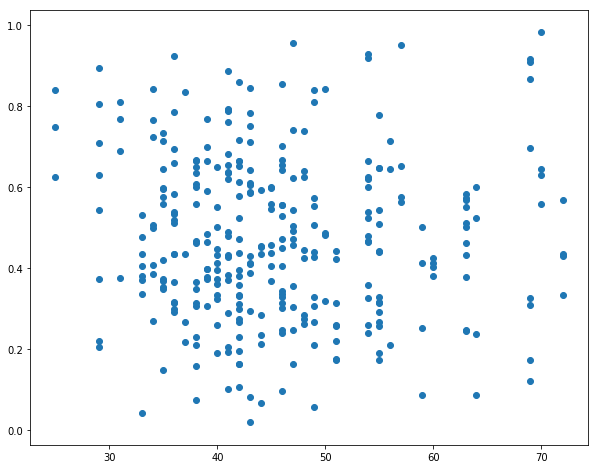

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(y, X)

0.0013254127234648694
100.40415854418099


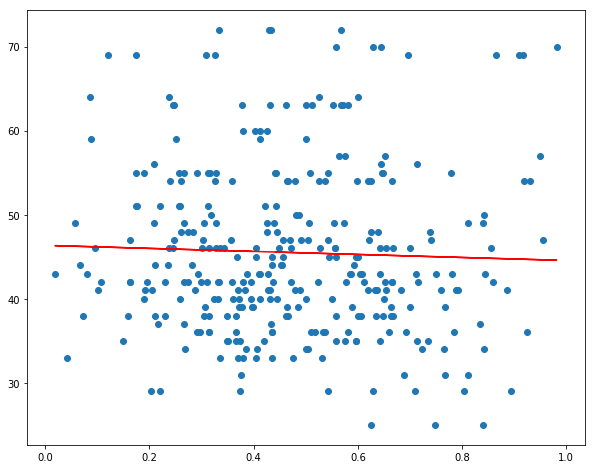

In [34]:
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X.values.reshape(-1, 1), y)
model_pred = lin_reg.predict(X.values.reshape(-1,1))
plt.figure(figsize=(10,8));
plt.scatter(X, y);
plt.plot(X, model_pred, color='r');
print(r2_score(y, model_pred))
print(mean_squared_error(y, model_pred))

In [36]:
# Really bad results, let's go polynomial
from sklearn.preprocessing import PolynomialFeatures

# Degree 2, parabolic function
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X.values.reshape(-1, 1))

0.0037532304494486413
100.16007203293732


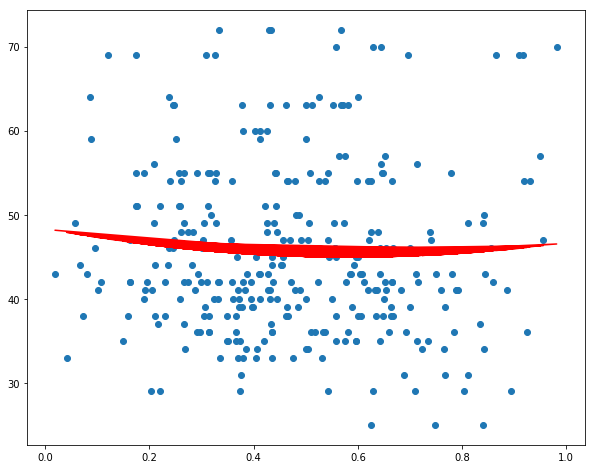

In [38]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y.values.reshape(-1, 1))
y_pred = lin_reg_2.predict(X_poly)
plt.figure(figsize=(10,8));
plt.scatter(X, y);
plt.plot(X, y_pred, color='r');
print(r2_score(y, y_pred))
print(mean_squared_error(y, y_pred))

In [40]:
# Degree 3, 
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X.values.reshape(-1, 1))

0.014048403473460591
99.1250219798849


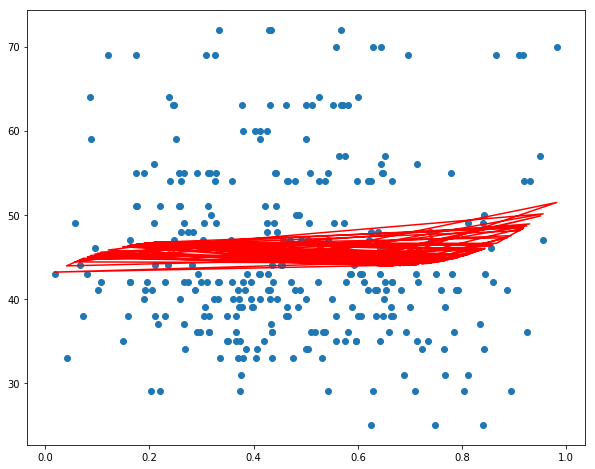

In [41]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y.values.reshape(-1, 1))
y_pred = lin_reg_2.predict(X_poly)
plt.figure(figsize=(10,8));
plt.scatter(X, y);
plt.plot(X, y_pred, color='r');
print(r2_score(y, y_pred))
print(mean_squared_error(y, y_pred))

In [43]:
X = tasnlp_df[["mean-sentiment", "es-len"]]
y = tasnlp_df["TAS20"]

In [47]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

model_pred = lin_reg.predict(X)

print(r2_score(y, model_pred))
print(mean_squared_error(y, model_pred))

0.0134372552299451
99.18646524270314


In [48]:
X = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude"]]
y = tasnlp_df["TAS20"]

In [49]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

model_pred = lin_reg.predict(X)

print(r2_score(y, model_pred))
print(mean_squared_error(y, model_pred))

0.015879808794987738
98.94089722833522


In [50]:
X = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude", "nlu-fear", "nlu-joy", "nlu-disgust", "nlu-anger", "nlu-sadness"]]
y = tasnlp_df["TAS20"]

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

model_pred = lin_reg.predict(X)

print(r2_score(y, model_pred))
print(mean_squared_error(y, model_pred))

0.023782399041220037
98.14639125601823


In [52]:
X = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude", "nlu-fear", "nlu-joy", "nlu-disgust", "nlu-anger", "nlu-sadness"]]
y = tasnlp_df["TAS20"]

In [58]:
# Degree 3, 
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

In [59]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y)
y_pred = lin_reg_2.predict(X_poly)

print(r2_score(y, y_pred))
print(mean_squared_error(y, y_pred))

0.41119715769521625
59.19671400796737


In [82]:
X = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude", "nlu-fear", "nlu-joy", "nlu-disgust", "nlu-anger", "nlu-sadness"]]
y = tasnlp_df["TAS20"]

In [101]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)

In [102]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y)
y_pred = lin_reg_2.predict(X_poly)

print(r2_score(y, y_pred))
print(mean_squared_error(y, y_pred))

0.9942689334212975
0.5761866024492794


In [112]:
results = pd.DataFrame({'TAS20':y,'P-TAS20':y_pred})

In [114]:
results.head()

,TAS20,P-TAS20
0,39.0,39.287178
1,39.0,39.220022
2,39.0,38.785001
3,63.0,63.097653
4,63.0,62.918395


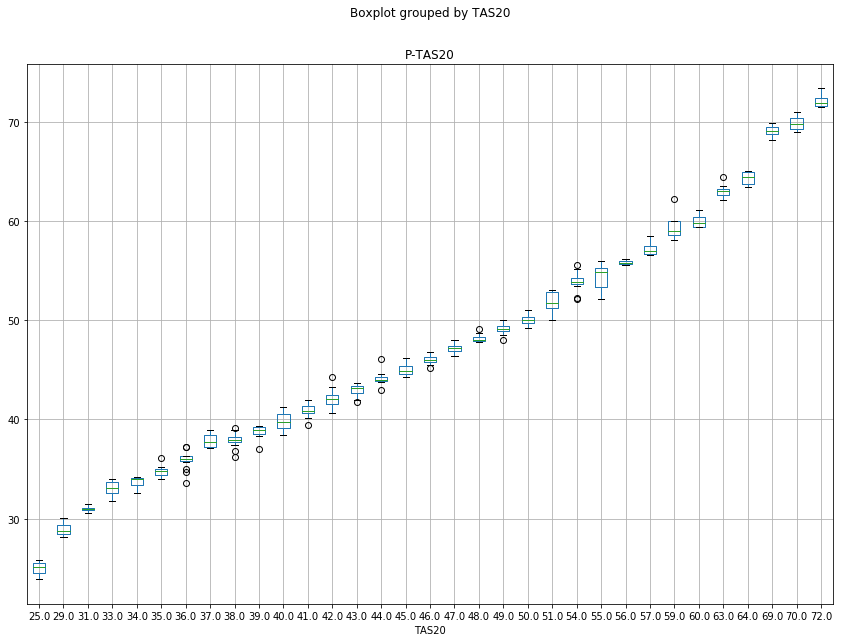

In [122]:
results.boxplot(by="TAS20", column="P-TAS20", figsize=[14,10], fontsize=10)

In [ ]:
lin